In [ ]:
# we have given a dataset containing details about new COVID-19 cases recorded in India on daily
# basis as a csv file (daily_covid_cases.csv). It shows the rolling 7-day average of newly
# confirmed cases starting from 30th-Jan-2020 to 2-Oct-2021. Rows are indexed with dates; the first
# column represents the date and the second column represents the new COVID-19 cases recorded
# that day. We will use this dataset to build an autoregression (AR) model

In [3]:
# importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm
import math
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Q1. Autocorrelation line plot with lagged values:
# a. Create a line plot with the x-axis as index of the day and y-axis as the number of Covid-19
# cases, as given below. Observe the first wave (around August-2020) and second wave
# (May-2021) of COVID-19 in India

In [4]:
# reading the csv file
df= pd.read_csv('daily_covid_cases.csv')
df.head()

,Date,new_cases
0,2020-01-30,0.00000
1,2020-01-31,0.00000
2,2020-02-01,0.33333
3,2020-02-02,0.50000
4,2020-02-03,0.60000


In [5]:
df.describe()

,new_cases
count,612.000000
mean,55136.431263
std,79411.278805
min,0.000000
25%,11742.964283
50%,34922.214285
75%,59073.821427
max,391232.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       612 non-null    object 
 1   new_cases  612 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.7+ KB


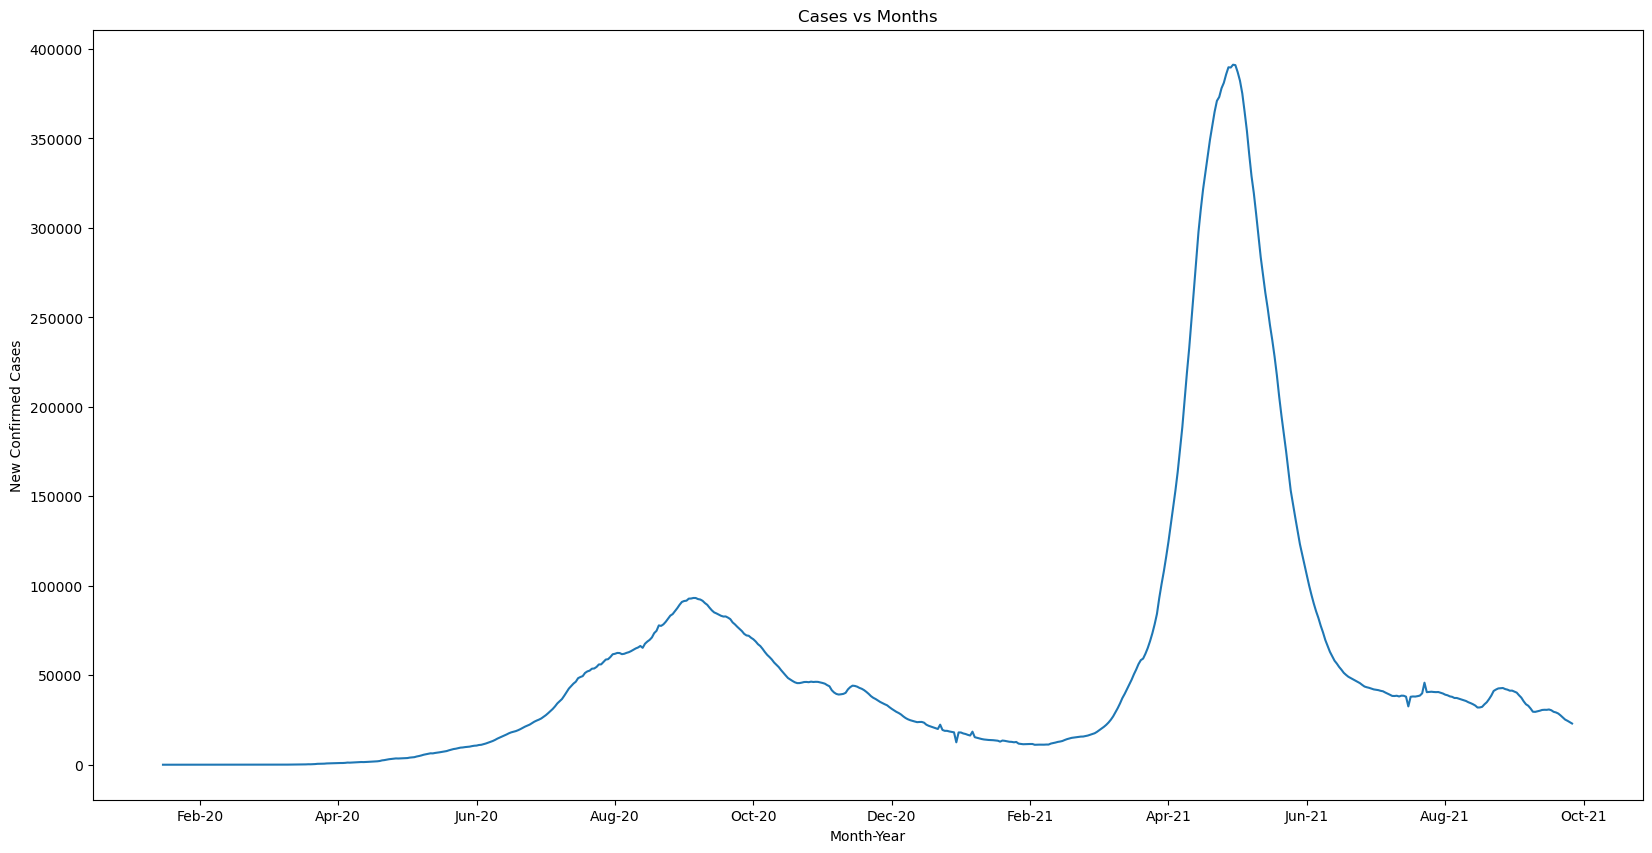

In [7]:
# Q1-(a)

# generating the x-ticks
x = [16]
for i in range(10):
    x.append(x[i] + 60)

# listing labels for the Month-Year
labels = ['Feb-20', 'Apr-20', 'Jun-20', 'Aug-20', 'Oct-20', 'Dec-20', 'Feb-21', 'Apr-21', 'Jun-21', 'Aug-21', 'Oct-21']
original= df['new_cases']
plt.figure(figsize=(20, 10))
plt.xticks(x, labels)
plt.xlabel('Month-Year')
plt.ylabel('New Confirmed Cases')
plt.title('Cases vs Months')
plt.plot(original)
plt.show()


In [ ]:
# Q1-b. Generate another time sequence with a one-day lag to the given time sequence. Find the
# Pearson correlation (autocorrelation) coefficient between the generated one-day lag time
# sequence and the given time sequence

In [8]:
# (b)
# generating time series with 1 day lag
lagged = df['new_cases'].shift(1)

lagged.head()

0        NaN
1    0.00000
2    0.00000
3    0.33333
4    0.50000
Name: new_cases, dtype: float64

In [9]:
corr = pearsonr(lagged[1:], original[1:])
print("The autocorrelation coefficient between the generated one-day lag time sequence and the given time sequence =",
      round(corr[0], 3))

The autocorrelation coefficient between the generated one-day lag time sequence and the given time sequence = 0.999


In [ ]:
# Q1-c. Generate a scatter plot between the given time sequence and one-day lagged generated
# sequence in 1.b. What do you infer regarding correlation? Does it match with the computed
# correlation coefficient in 1.b?

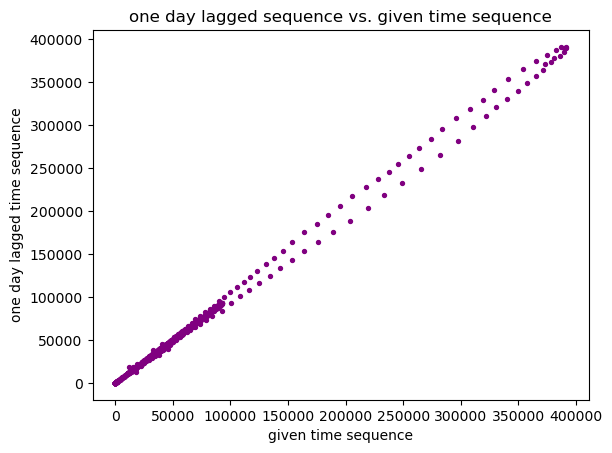

In [12]:
# Q1-(c)
# scatter plot between one day lagged sequence and given time sequence
plt.xlabel('given time sequence')
plt.ylabel('one day lagged time sequence')
plt.title('one day lagged sequence vs. given time sequence')
plt.scatter(original[1:], lagged[1:] , color='purple',s=8)
plt.show()

In [ ]:
# Q1-d. Generate multiple time sequences with different lag values (1-day, 2-days, 3-days up to 6-
# days). Compute the Pearson correlation coefficient between each of the generated time
# sequences and the given time sequence. Create a line plot between obtained correlation
# coefficients (on the y-axis) and lagged values (on the x-axis).

The correlation coefficient between each of the generated time sequences and the given time sequence:
1-day = 0.999
2-day = 0.996
3-day = 0.992
4-day = 0.986
5-day = 0.978
6-day = 0.969


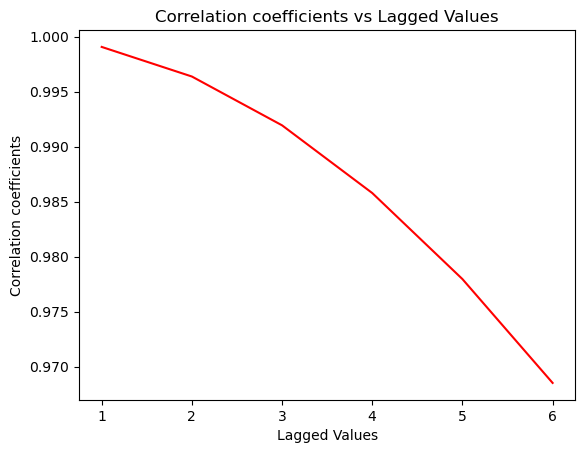

In [13]:
# lag values
lag = [1, 2, 3, 4, 5, 6]
correlation = []
print("The correlation coefficient between each of the generated time sequences and the given time sequence:")
for d in lag:
    lagged = df['new_cases'].shift(d)
    corr = pearsonr(lagged[d:], original[d:])
    correlation.append(corr[0])
    print(f"{d}-day =", round(corr[0],3))
# line plot of correlation coefficients vs lagged values
plt.xlabel('Lagged Values')
plt.ylabel('Correlation coefficients')
plt.title('Correlation coefficients vs Lagged Values')
plt.plot(lag, correlation , color='red')
plt.show()

In [ ]:
# Q1-e. Plot a correlogram or Auto Correlation Function using python inbuilt function
# ‘plot_acf’. Observe the trend in the line plot with increase in lagged values and relate
# with that of 1 d.

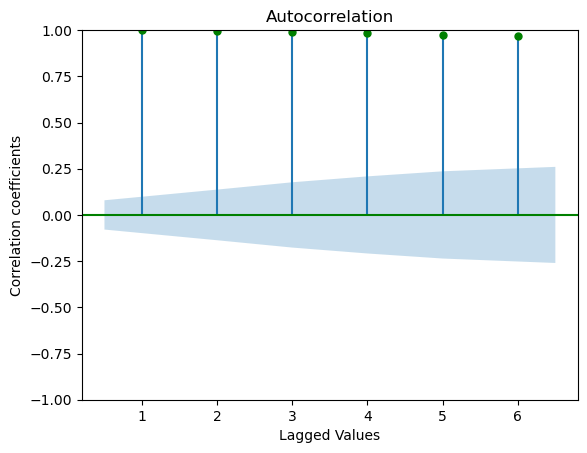

In [14]:
sm.graphics.tsa.plot_acf(original,lags=lag,color='green')
plt.xlabel('Lagged Values')
plt.ylabel('Correlation coefficients')
plt.show()

In [ ]:
# Q2. A general autoregression (AR) model estimates the unknown data values as a linear
# combination of given lagged data values. For example, data value at (t+1) instant, denoted by
# x(t+1), can be estimated from its previous instance values, such as x(t+1) = w0 + w1*x(t) +
# w2*x(t-1) + … + wp*x(t-p+1). The coefficients w0, w1, … wp can be estimated while training
# the autoregression model on training dataset.

In [ ]:
# Q2-a. Splitting the data into two parts. The initial 65% of the sequence for training data and the
# remaining 35% of the sequence as test data. (You may use slicing operation for the same
# to maintain the order of the sequence. Note that, you should not shuffle randomly.) This
# test set approximately covers the second wave of COVID-19. Plot the train and test sets.
# Generate an autoregression (AR) model using AutoReg() function from
# statsmodels library. This function generates an AR model with the specified training
# data and lagged values (given as its input). Use 5 lagged values as its input (p=5).
# Train/Fit the model onto the training dataset. Obtain the coefficients (w0, w1, ..., wp) from
# the trained AR model.

In [15]:
# Q2-(a)
# Train - test split
series = pd.read_csv('daily_covid_cases.csv', parse_dates=['Date'],index_col=['Date'],sep=',')
test_size = 0.35 # 35% for testing
X = series.values
tst_sz = math.ceil(len(X)*test_size)
train, test = X[:len(X)-tst_sz], X[len(X)-tst_sz:]

In [16]:
train

array([[0.00000000e+00],
       [0.00000000e+00],
       [3.33330000e-01],
       [5.00000000e-01],
       [6.00000000e-01],
       [5.00000000e-01],
       [4.28570000e-01],
       [2.85710000e-01],
       [2.85710000e-01],
       [2.85710000e-01],
       [1.42860000e-01],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [2.85710000e-01],
       [2.85710000e-01],
       [3.57143000e+00],
       [3.85714000e+00],
       [4.00000000e+00],
       [4.42857000e+00],
       [5.14286000e+00],
       [5.42857000e+00],


In [17]:
test

array([[ 15620.     ],
       [ 15715.57143],
       [ 15752.85714],
       [ 16009.42857],
       [ 16295.42857],
       [ 16736.71429],
       [ 17179.85714],
       [ 17598.71429],
       [ 18376.85714],
       [ 19297.85714],
       [ 20240.42857],
       [ 21178.42857],
       [ 22277.28571],
       [ 23577.85714],
       [ 25146.71429],
       [ 27006.28571],
       [ 29355.     ],
       [ 31650.85714],
       [ 34297.42857],
       [ 37248.85714],
       [ 39566.42857],
       [ 42189.14286],
       [ 44704.14286],
       [ 47474.42857],
       [ 50518.     ],
       [ 53213.42857],
       [ 56223.28571],
       [ 58437.     ],
       [ 59325.28571],
       [ 62018.71429],
       [ 65211.28571],
       [ 69050.     ],
       [ 73412.14286],
       [ 78489.     ],
       [ 84313.42857],
       [ 93207.14286],
       [100987.     ],
       [108201.57143],
       [116238.     ],
       [124756.57143],
       [134092.85714],
       [143343.42857],
       [153148.57143],
       [163

In [18]:
# training the model
p = 5
model = AutoReg(train, lags=p)
# fit/train the model
model_fit = model.fit()
# Get the coefficients of AR model 
coef = model_fit.params 
# printing the coefficients
print('The coefficients obtained from the AR model are', coef)

The coefficients obtained from the AR model are [ 5.99548333e+01  1.03675933e+00  2.61712336e-01  2.75612628e-02
 -1.75391955e-01 -1.52461366e-01]


In [ ]:
# Q2-b. Using these coefficients, predict the values (using the relation given above) for the test
# dataset. Note that, you have to make a 1-step ahead prediction each time. An example
# code snippet is given below (Code snippet to train AR model and predict
# using the coefficients).
# i. Give a scatter plot between actual and predicted values.
# ii. Give a line plot showing actual and predicted test values.
# iii. Compute RMSE (%) and MAPE between actual and predicted test data

In [19]:
# Q2-(b)

#using these coefficients walk forward over time steps in test, one step each time
history = train[len(train)-p:]
history = [history[i] for i in range(len(history))]
predicted = list() # List to hold the predictions, 1 step at a time for t in range(len(test)):
for t in range(len(test)):
  length = len(history)
  Lag = [history[i] for i in range(length-p,length)] 
  yhat = coef[0] # Initialize to w0
  for d in range(p):
    yhat += coef[d+1] * Lag[p-d-1] # Add other values 
  obs = test[t]
  predicted.append(yhat) #Append predictions to compute RMSE later
  history.append(obs) # Append actual test value to history, to be used in next step.


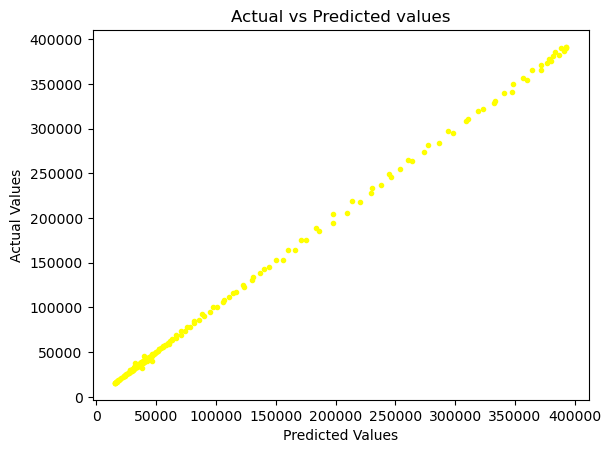

In [20]:
# Q2(b)-(i)
# scatter plot between actual and predicted values
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs Predicted values')
plt.scatter(predicted, test, color='yellow', s=9)
plt.show()


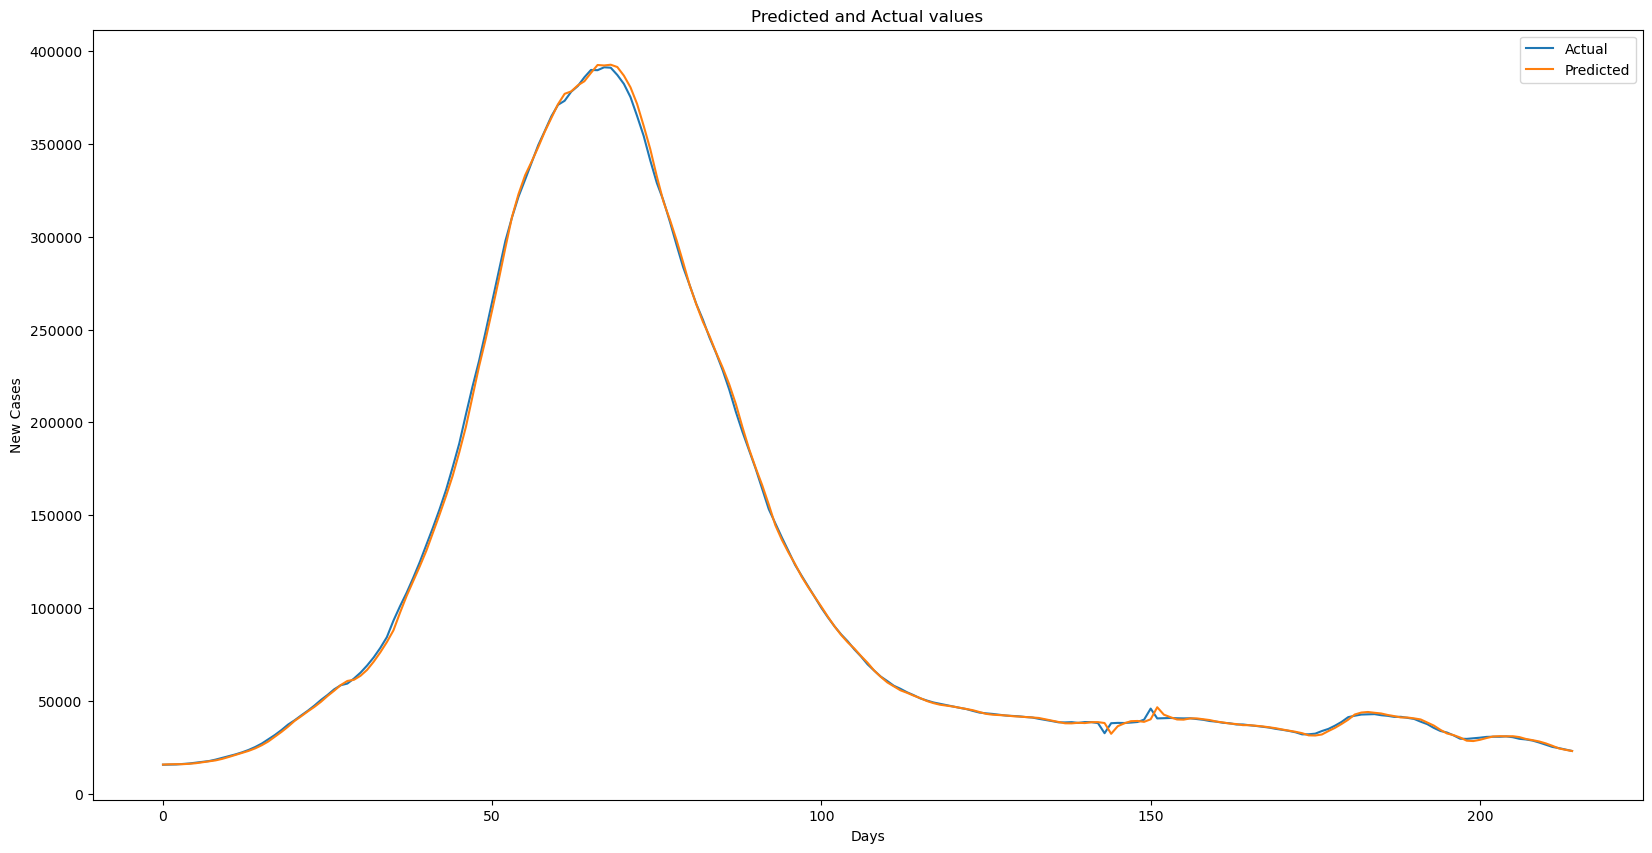

In [22]:
# Q2(b)-(ii)
# line plot between actual and predicted values
plt.figure(figsize=(20, 10))
plt.xlabel('Days')
plt.ylabel('New Cases')
plt.title('Predicted and Actual values')
plt.plot(test , label="Actual")
plt.plot(predicted , label="Predicted")
plt.legend()
plt.show()

In [25]:
# 2(b)-(iii)

# computing rmse
rmse_per = (math.sqrt(mean_squared_error(test, predicted))/np.mean(test))*100
print('RMSE(%):',rmse_per)

# computing MAPE
mape = np.mean(np.abs((test - predicted)/test))*100
print('MAPE(%):',mape)


RMSE(%): 1.8247684769390666
MAPE(%): 1.5748363824058187


In [ ]:
# Q3. Generate five AR models using AutoReg() function with lag values as 1, 5, 10, 15 and 25
# days. Compute the RMSE (%) and MAPE between predicted and original test data values in
# each case. Give a bar chart showing RMSE (%) on the y-axis and lagged values on the x-axis.
# Also, give a bar chart showing MAPE on the y-axis and lagged values on the x-axis. Infer the
# changes in RMSE (%) and MAPE with changes in lagged values.

In [27]:
lag_val = [1,5,10,15,25]
RMSE = []
MAPE = []
for l in lag_val:
  model = AutoReg(train, lags=l)
  # fit/train the model
  model_fit = model.fit()
  coef = model_fit.params 
  history = train[len(train)-l:]
  history = [history[i] for i in range(len(history))]
  predicted = list() # List to hold the predictions, 1 step at a time for t in range(len(test)):
  for t in range(len(test)):
    length = len(history)
    Lag = [history[i] for i in range(length-l,length)] 
    yhat = coef[0] # Initialize to w0
    for d in range(l):
      yhat += coef[d+1] * Lag[l-d-1] # Add other values 
    obs = test[t]
    predicted.append(yhat) #Append predictions to compute RMSE later
    history.append(obs) # Append actual test value to history, to be used in next step.

  # computing rmse
  rmse_per = (math.sqrt(mean_squared_error(test, predicted))/np.mean(test))*100
  RMSE.append(rmse_per)

  # computing MAPE
  mape = np.mean(np.abs((test - predicted)/test))*100
  MAPE.append(mape)

# RMSE (%) and MAPE between predicted and original data values wrt lags in time sequence
data = {'Lag value':lag_val,'RMSE(%)':RMSE, 'MAPE(%)' :MAPE}
print('Table 1\n',pd.DataFrame(data))


Table 1
    Lag value   RMSE(%)   MAPE(%)
0          1  5.372948  3.446540
1          5  1.824768  1.574836
2         10  1.685532  1.519370
3         15  1.611935  1.496236
4         25  1.703391  1.535421


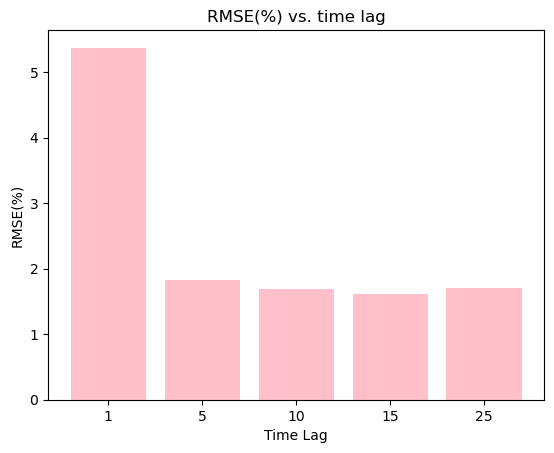

In [28]:
# plotting RMSE(%) vs. time lag
plt.xlabel('Time Lag')
plt.ylabel('RMSE(%)')
plt.title('RMSE(%) vs. time lag')
plt.xticks([1,2,3,4,5],lag_val)
plt.bar([1,2,3,4,5],RMSE,color='pink')
plt.show()

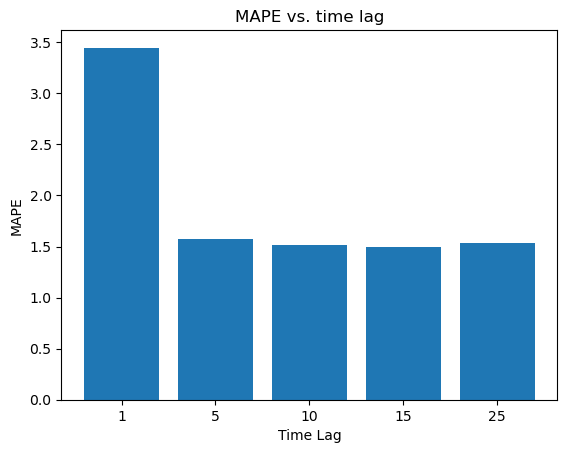

In [29]:
# plotting MAPE vs. time lag
plt.xlabel('Time Lag')
plt.ylabel('MAPE')
plt.title('MAPE vs. time lag')
plt.xticks([1,2,3,4,5],lag_val)
plt.bar([1,2,3,4,5],MAPE)
plt.show()

In [ ]:
# Q4. Compute the heuristic value for the optimal number of lags up to the condition on
# autocorrelation such that abs(AutoCorrelation) > 2/sqrt(T), where T is the number of
# observations in training data. Use it as input in AutoReg() function to predict the new
# COVID-19 cases on daily basis and compute the RMSE(%) and MAPE value. Compare this
# result with that of Question 3

In [33]:
# computing number of optimal value of p
p = 1
while p < len(df):
  corr = pearsonr(train[p:].ravel(), train[:len(train)-p].ravel())
  if(abs(corr[0]) <= 2/math.sqrt(len(train[p:]))):
    print('The heuristic value for the optimal number of lags(P) is',p-1)
    break
  p+=1

p=p-1
# training the model
model = AutoReg(train, lags=p)
# fit/train the model
model_fit = model.fit()
coef = model_fit.params 
history = train[len(train)-p:]
history = [history[i] for i in range(len(history))]
predicted = list() # List to hold the predictions, 1 step at a time for t in range(len(test)):
for t in range(len(test)):
  length = len(history)
  Lag = [history[i] for i in range(length-p,length)] 
  yhat = coef[0] # Initialize to w0
  for d in range(p):
    yhat += coef[d+1] * Lag[p-d-1] # Add other values 
  obs = test[t]
  predicted.append(yhat) #Append predictions to compute RMSE later
  history.append(obs) # Append actual test value to history, to be used in next step.

# computing rmse
rmse_per = (math.sqrt(mean_squared_error(test, predicted))/np.mean(test))*100
print('RMSE(%):',rmse_per)

# computing MAPE
mape = np.mean(np.abs((test - predicted)/test))*100
print('MAPE(%):',mape)

The heuristic value for the optimal number of lags(P) is 77
RMSE(%): 1.7593780528851293
MAPE(%): 2.0264439052806633


In [ ]:
# Take the full data (jan 30 2020 to oct 2 2021). Build AR model for last p-lag[observed in Q4]
# predict new cases for oct 3 taking oct 2 values as input.
# predict new cases for oct 4 taking predicted values of oct 3 as input.
# do it till feb 25 2022. can you observe any peak.

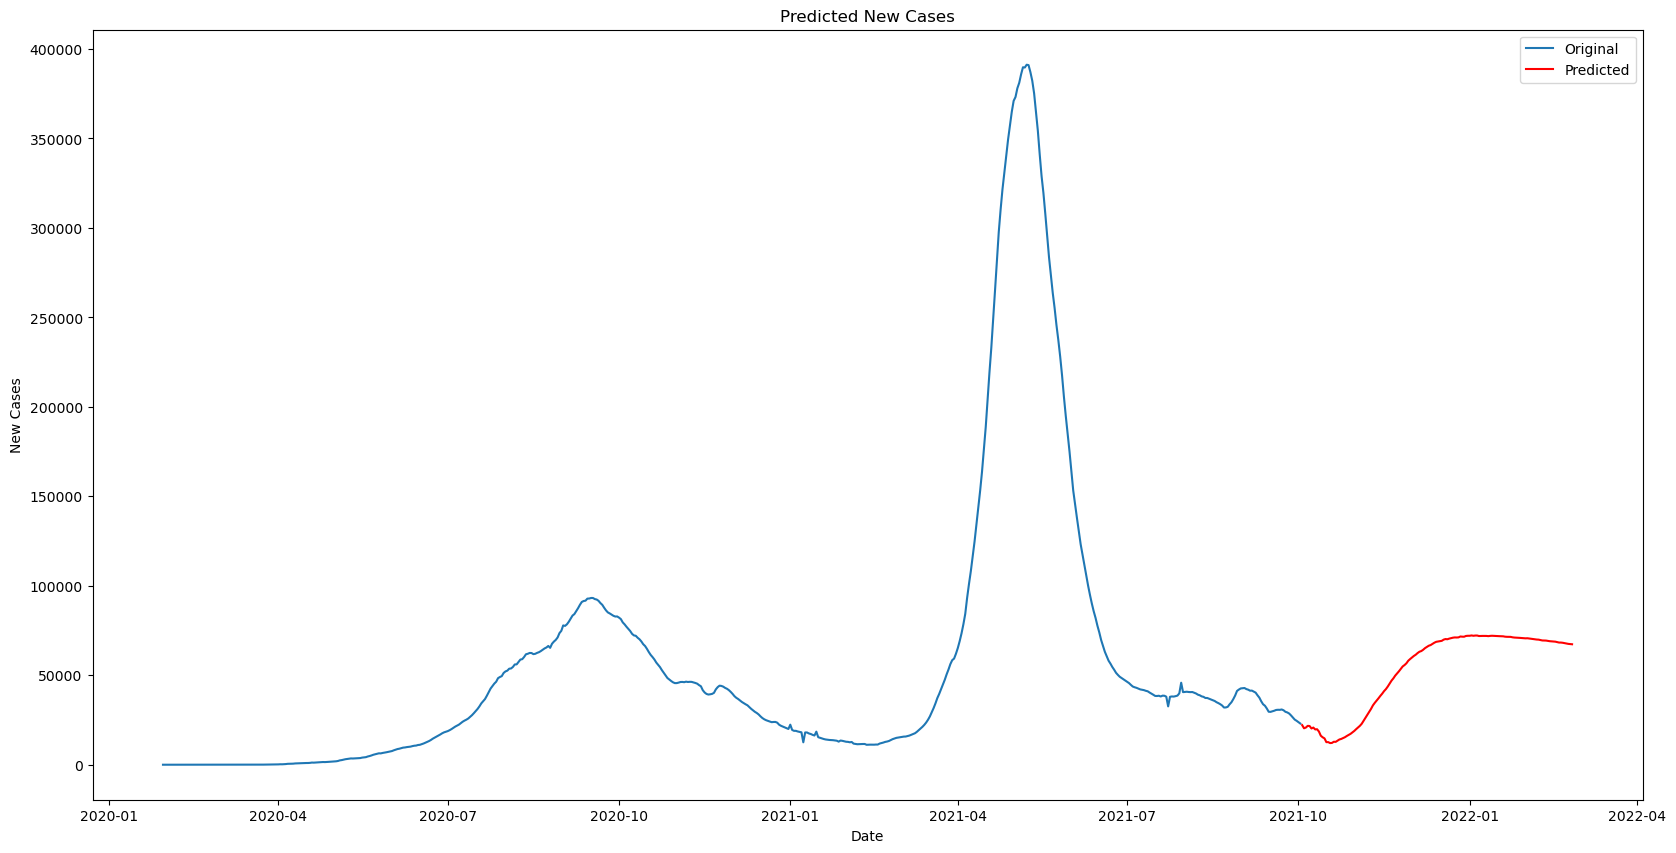

In [52]:
# Determine the optimal lag value (p) from Q4
p = 77 # Replace with the optimal lag value obtained from Q4

# Train the AR model using the full data
model = AutoReg(series, lags=p)
model_fit = model.fit()
coef = model_fit.params

# Predict new cases from October 3, 2021, to February 25, 2022
start_date = pd.to_datetime('2021-10-03')
end_date = pd.to_datetime('2022-02-25')
prediction_dates = pd.date_range(start=start_date, end=end_date)

predicted_values = []
previous_value = series[-p:].values  # Last p values from the training data

for date in prediction_dates:
    lagged_values = previous_value[-p:]  # Get lagged values from the previous day
    predicted_value = coef[0]  # Initialize with the intercept term

    for i in range(p):
        predicted_value += coef[i + 1] * lagged_values[p - i - 1]  # Multiply coefficients with lagged values

    predicted_values.append(predicted_value)
    previous_value = np.append(previous_value, predicted_value)

# Plot the predicted values
plt.figure(figsize=(20, 10))
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.title('Predicted New Cases')
plt.plot(series.index, series.values, label='Original')
plt.plot(prediction_dates, predicted_values, label='Predicted', color='red')
plt.legend()
plt.show()


In [53]:
# Find the peak in the predicted values and its corresponding date
peak_index = np.argmax(predicted_values)
peak_date = prediction_dates[peak_index]
peak_value = predicted_values[peak_index]

# Print the peak date and value
print("Peak Date:", peak_date)
print("Peak Value:", peak_value)


Peak Date: 2022-01-02 00:00:00
Peak Value: 72247.66681441134
